In [1]:
import tensorflow as tf
import os
import glob
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
tf.set_random_seed(0)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

import numpy as np
np.random.seed(0)

from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract
from keras.models import Model, load_model
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
import keras.backend as K

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import keras
print(keras.__version__)

2.1.6


In [3]:
train_input_dir = 'CVC-612/bbdd_png'
train_label_dir = 'CVC-612/gtspecular_png'

train_input_paths = glob.glob(os.path.join(train_input_dir, '*.png'))
train_label_paths = glob.glob(os.path.join(train_label_dir, '*.png'))

train_input_paths = np.asarray(train_input_paths)
train_label_paths = np.asarray(train_label_paths)

print('Number of dataset is {}'.format(len(train_input_paths)))

# shuffle
print('Shuffle...')
indices = np.arange(0, len(train_input_paths))
np.random.shuffle(indices)

train_input_paths = train_input_paths[indices]
train_label_paths = train_label_paths[indices]

# split
print('Split...')
val_split = 0.2
num_val = int(len(train_input_paths) * 0.2)

val_input_paths = train_input_paths[:num_val]
val_label_paths = train_label_paths[:num_val]

train_input_paths = train_input_paths[num_val:]
train_label_paths = train_label_paths[num_val:]

print('Number of training set is {}'.format(len(train_input_paths)))
print('Number of valdation set is {}'.format(len(val_input_paths)))

Number of dataset is 612
Shuffle...
Split...
Number of training set is 490
Number of valdation set is 122


In [4]:
def parse_data_aug(input_filename, target_filename):
    input_image = tf.read_file(input_filename)
    target_image = tf.read_file(target_filename)
    
    input_image = tf.image.decode_image(input_image)
    target_image = tf.image.decode_image(target_image)
    
    # 堆叠图像，使得两张图片能做相同的变换
    stacked_image = tf.concat([input_image, target_image], axis=2)
    
    # 数据增强
    crop_stacked_image = tf.image.random_flip_left_right(stacked_image)
    crop_stacked_image = tf.image.random_flip_up_down(crop_stacked_image)

    # 切片
    crop_input_image, crop_target_image = tf.split(crop_stacked_image, [3,1], axis=2)
    
    # 对输入图片再做一些变换
    crop_input_image = tf.image.random_brightness(crop_input_image, 0.3)
    
    # 归一化
    crop_input_image = tf.cast(crop_input_image, tf.float32) / 255.0
    crop_target_image = tf.cast(tf.cast(crop_target_image, tf.float32) / 255.0, tf.int32)
    
    
    return crop_input_image,crop_target_image

def parse_data_without_aug(input_filename, target_filename):
    input_image = tf.read_file(input_filename)
    target_image = tf.read_file(target_filename)
    
    input_image = tf.image.decode_image(input_image)
    target_image = tf.image.decode_image(target_image, channels=1)
    
    # 堆叠图像，使得两张图片能做相同的变换
    stacked_image = tf.concat([input_image, target_image], axis=2)

    
    # 数据增强
    # 切片
    crop_input_image, crop_target_image = tf.split(stacked_image, [3,1], axis=2)
    
    # 归一化
    crop_input_image = tf.cast(input_image, tf.float32) / 255.0
    crop_target_image = tf.cast(tf.cast(crop_target_image, tf.float32) / 255.0, tf.int32)    
    
    return crop_input_image,crop_target_image

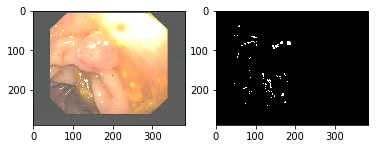

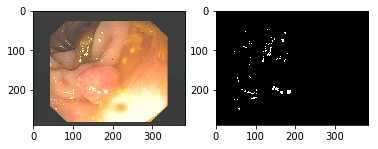

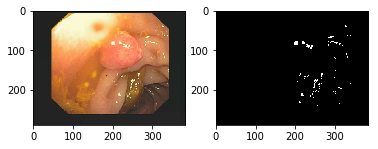

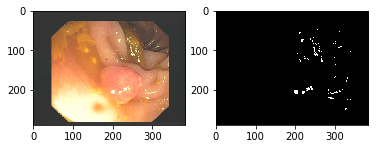

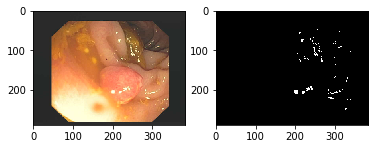

In [5]:
# 测试一下数据增强是不是正常运行
with tf.Session() as sess:
    for i in range(5):
        crop_input_image,crop_target_image = parse_data_aug(str(train_input_paths[0]), str(train_label_paths[0]))
        crop_input_image_val, crop_target_image_val = sess.run([crop_input_image,crop_target_image])
        plt.subplot(1,2,1)
        plt.imshow(crop_input_image_val)
        plt.subplot(1,2,2)
        plt.imshow(crop_target_image_val[:,:,0], cmap='gray')
        plt.show()

In [6]:
def train_generator(input_paths, label_paths, batchsize = 32, shuffle=True):
    with tf.Session() as sess:
        train_dataset = tf.data.Dataset().from_tensor_slices((input_paths, label_paths))

        train_dataset = train_dataset.map(parse_data_aug)

        train_dataset = train_dataset.batch(batchsize)
        train_dataset = train_dataset.repeat()

        train_dataset = train_dataset.shuffle(buffer_size=4)

        # 创建迭代器
        train_iterator = train_dataset.make_initializable_iterator()
        sess.run(train_iterator.initializer)
        train_batch = train_iterator.get_next()

        while True:
            try:
                x_batch, y_batch = sess.run(train_batch)
                yield (x_batch, y_batch)
            except:
                train_iterator = train_dataset.make_initializable_iterator()
                sess.run(train_iterator.initializer)
                train_batch = train_iterator.get_next()
                x_batch, y_batch = sess.run(train_batch)
                yield (x_batch, y_batch)

def val_generator(input_paths, label_paths, batchsize = 32):
    with tf.Session() as sess:
        train_dataset = tf.data.Dataset().from_tensor_slices((input_paths, label_paths))

        train_dataset = train_dataset.map(parse_data_without_aug)

        train_dataset = train_dataset.batch(batchsize)
        train_dataset = train_dataset.repeat()

        # 创建迭代器
        train_iterator = train_dataset.make_initializable_iterator()
        sess.run(train_iterator.initializer)
        train_batch = train_iterator.get_next()

        while True:
            try:
                x_batch, y_batch = sess.run(train_batch)
                yield (x_batch, y_batch)
            except:
                train_iterator = train_dataset.make_initializable_iterator()
                sess.run(train_iterator.initializer)
                train_batch = train_iterator.get_next()
                x_batch, y_batch = sess.run(train_batch)
                yield (x_batch, y_batch)

In [ ]:
def build_model(depth,filters=64,image_channels=1, use_bnorm=True):
    layer_count = 0
    inpt = Input(shape=(None,None,3),name = 'input'+str(layer_count))
    # 1st layer, Conv+relu
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'conv'+str(layer_count))(inpt)
    layer_count += 1
    x = Activation('relu',name = 'relu'+str(layer_count))(x)
    # depth-2 layers, Conv+BN+relu
    for i in range(depth-2):
        layer_count += 1
        x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
        if use_bnorm:
            layer_count += 1
            #x = BatchNormalization(axis=3, momentum=0.1,epsilon=0.0001, name = 'bn'+str(layer_count))(x) 
        x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
        layer_count += 1
        x = Activation('relu',name = 'relu'+str(layer_count))(x)  
    # last layer, Conv
    layer_count += 1
    x = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
    layer_count += 1
    x = Activation('sigmoid', name='sigmoid'+str(layer_count))(x)
#     x = Subtract(name = 'subtract' + str(layer_count))([inpt, x])   # input - noise
    model = Model(inputs=inpt, outputs=x)
    
    return model

model = build_model(17)
optimizer = Adam()
loss_fn = 'binary_crossentropy'
metrics=['acc']
model.compile(loss=loss_fn,
              optimizer=optimizer,metrics=metrics)

train_gen = train_generator(train_input_paths, train_label_paths, batchsize=2)
val_gen = val_generator(train_input_paths, train_label_paths, batchsize=2)

callback_list = [ModelCheckpoint('FCN_baseline.h5',save_best_only=True, verbose=1)]

history = model.fit_generator(train_gen,
                              steps_per_epoch=200, epochs=20,
                              validation_data=val_gen,
                              validation_steps=100,callbacks=callback_list)